In [172]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import xarray as xr

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [173]:
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

In [174]:
def make_scalarMap(m):
    return ScalarMappable(norm=Normalize(vmin=np.min(m), vmax=np.max(m)), cmap="viridis")

In [398]:
def load_data():
    try:
        df = pd.read_excel(r"C:\Users\Simon\Downloads\df_altman20.xlsx")
    except:
        df = pd.read_excel(r"C:\Users\Simon\Downloads\df_altman20.xlsx")

    x = df["ln_%_have_scf"].values
    m = df["ln_%_have_undisclosed_scf"].values
    y = df["Altman_Z"].values

    return (x, y, m)


x, y, m = load_data()

# Make a scalar color map for this dataset. Just for plotting.
scalarMap = make_scalarMap(m)

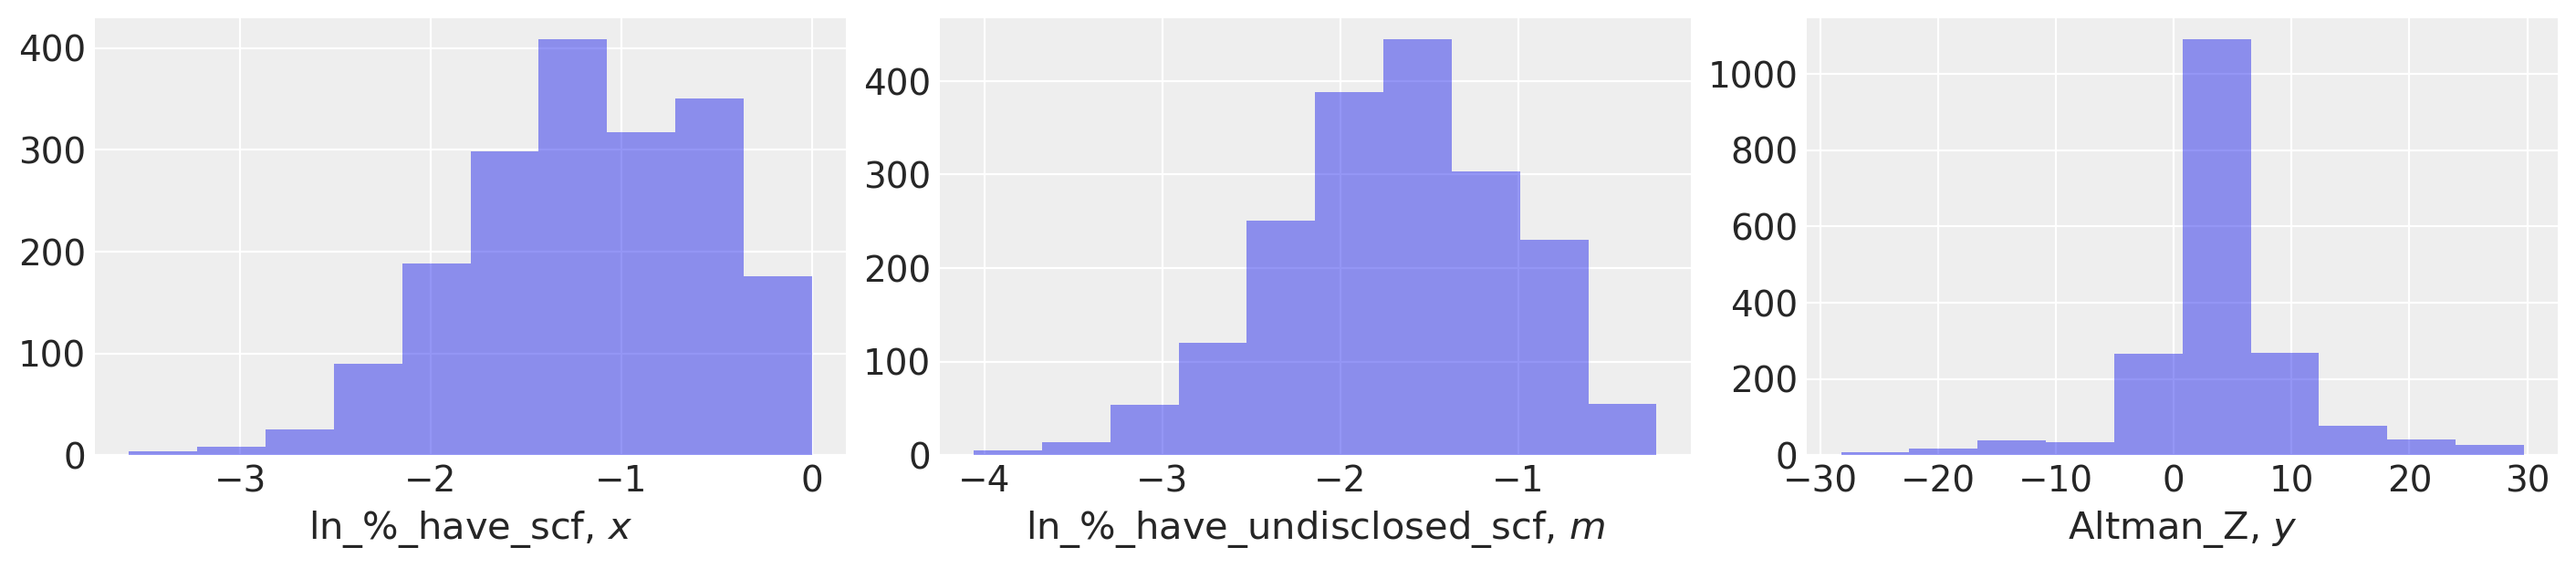

In [399]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3))

ax[0].hist(x, alpha=0.5)
ax[0].set(xlabel="ln_%_have_scf, $x$")

ax[1].hist(m, alpha=0.5)
ax[1].set(xlabel="ln_%_have_undisclosed_scf, $m$")

ax[2].hist(y, alpha=0.5)
ax[2].set(xlabel="Altman_Z, $y$");

In [400]:
def model_factory(x, m, y):
    with pm.Model() as model:
        x = pm.Data("x", x)
        m = pm.Data("m", m)
        # priors
        β0 = pm.Normal("β0", mu=0, sd=10)
        β1 = pm.Normal("β1", mu=0, sd=10)
        β2 = pm.Normal("β2", mu=0, sd=10)
        β3 = pm.Normal("β3", mu=0, sd=10)
        σ = pm.HalfCauchy("σ", 1)
        # likelihood
        y = pm.Normal("y", mu=β0 + (β1 * x) + (β2 * x * m) + (β3 * m), sd=σ, observed=y)

    return model

In [401]:
model = model_factory(x, m, y)

In [402]:
with model:
    result = pm.sample(
        2000,
        tune=2000,
        target_accept=0.9,
        random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"dims": {"x": ["obs_id"], "m": ["obs_id"], "y": ["obs_id"]}},
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β3, β2, β1, β0]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 83 seconds.


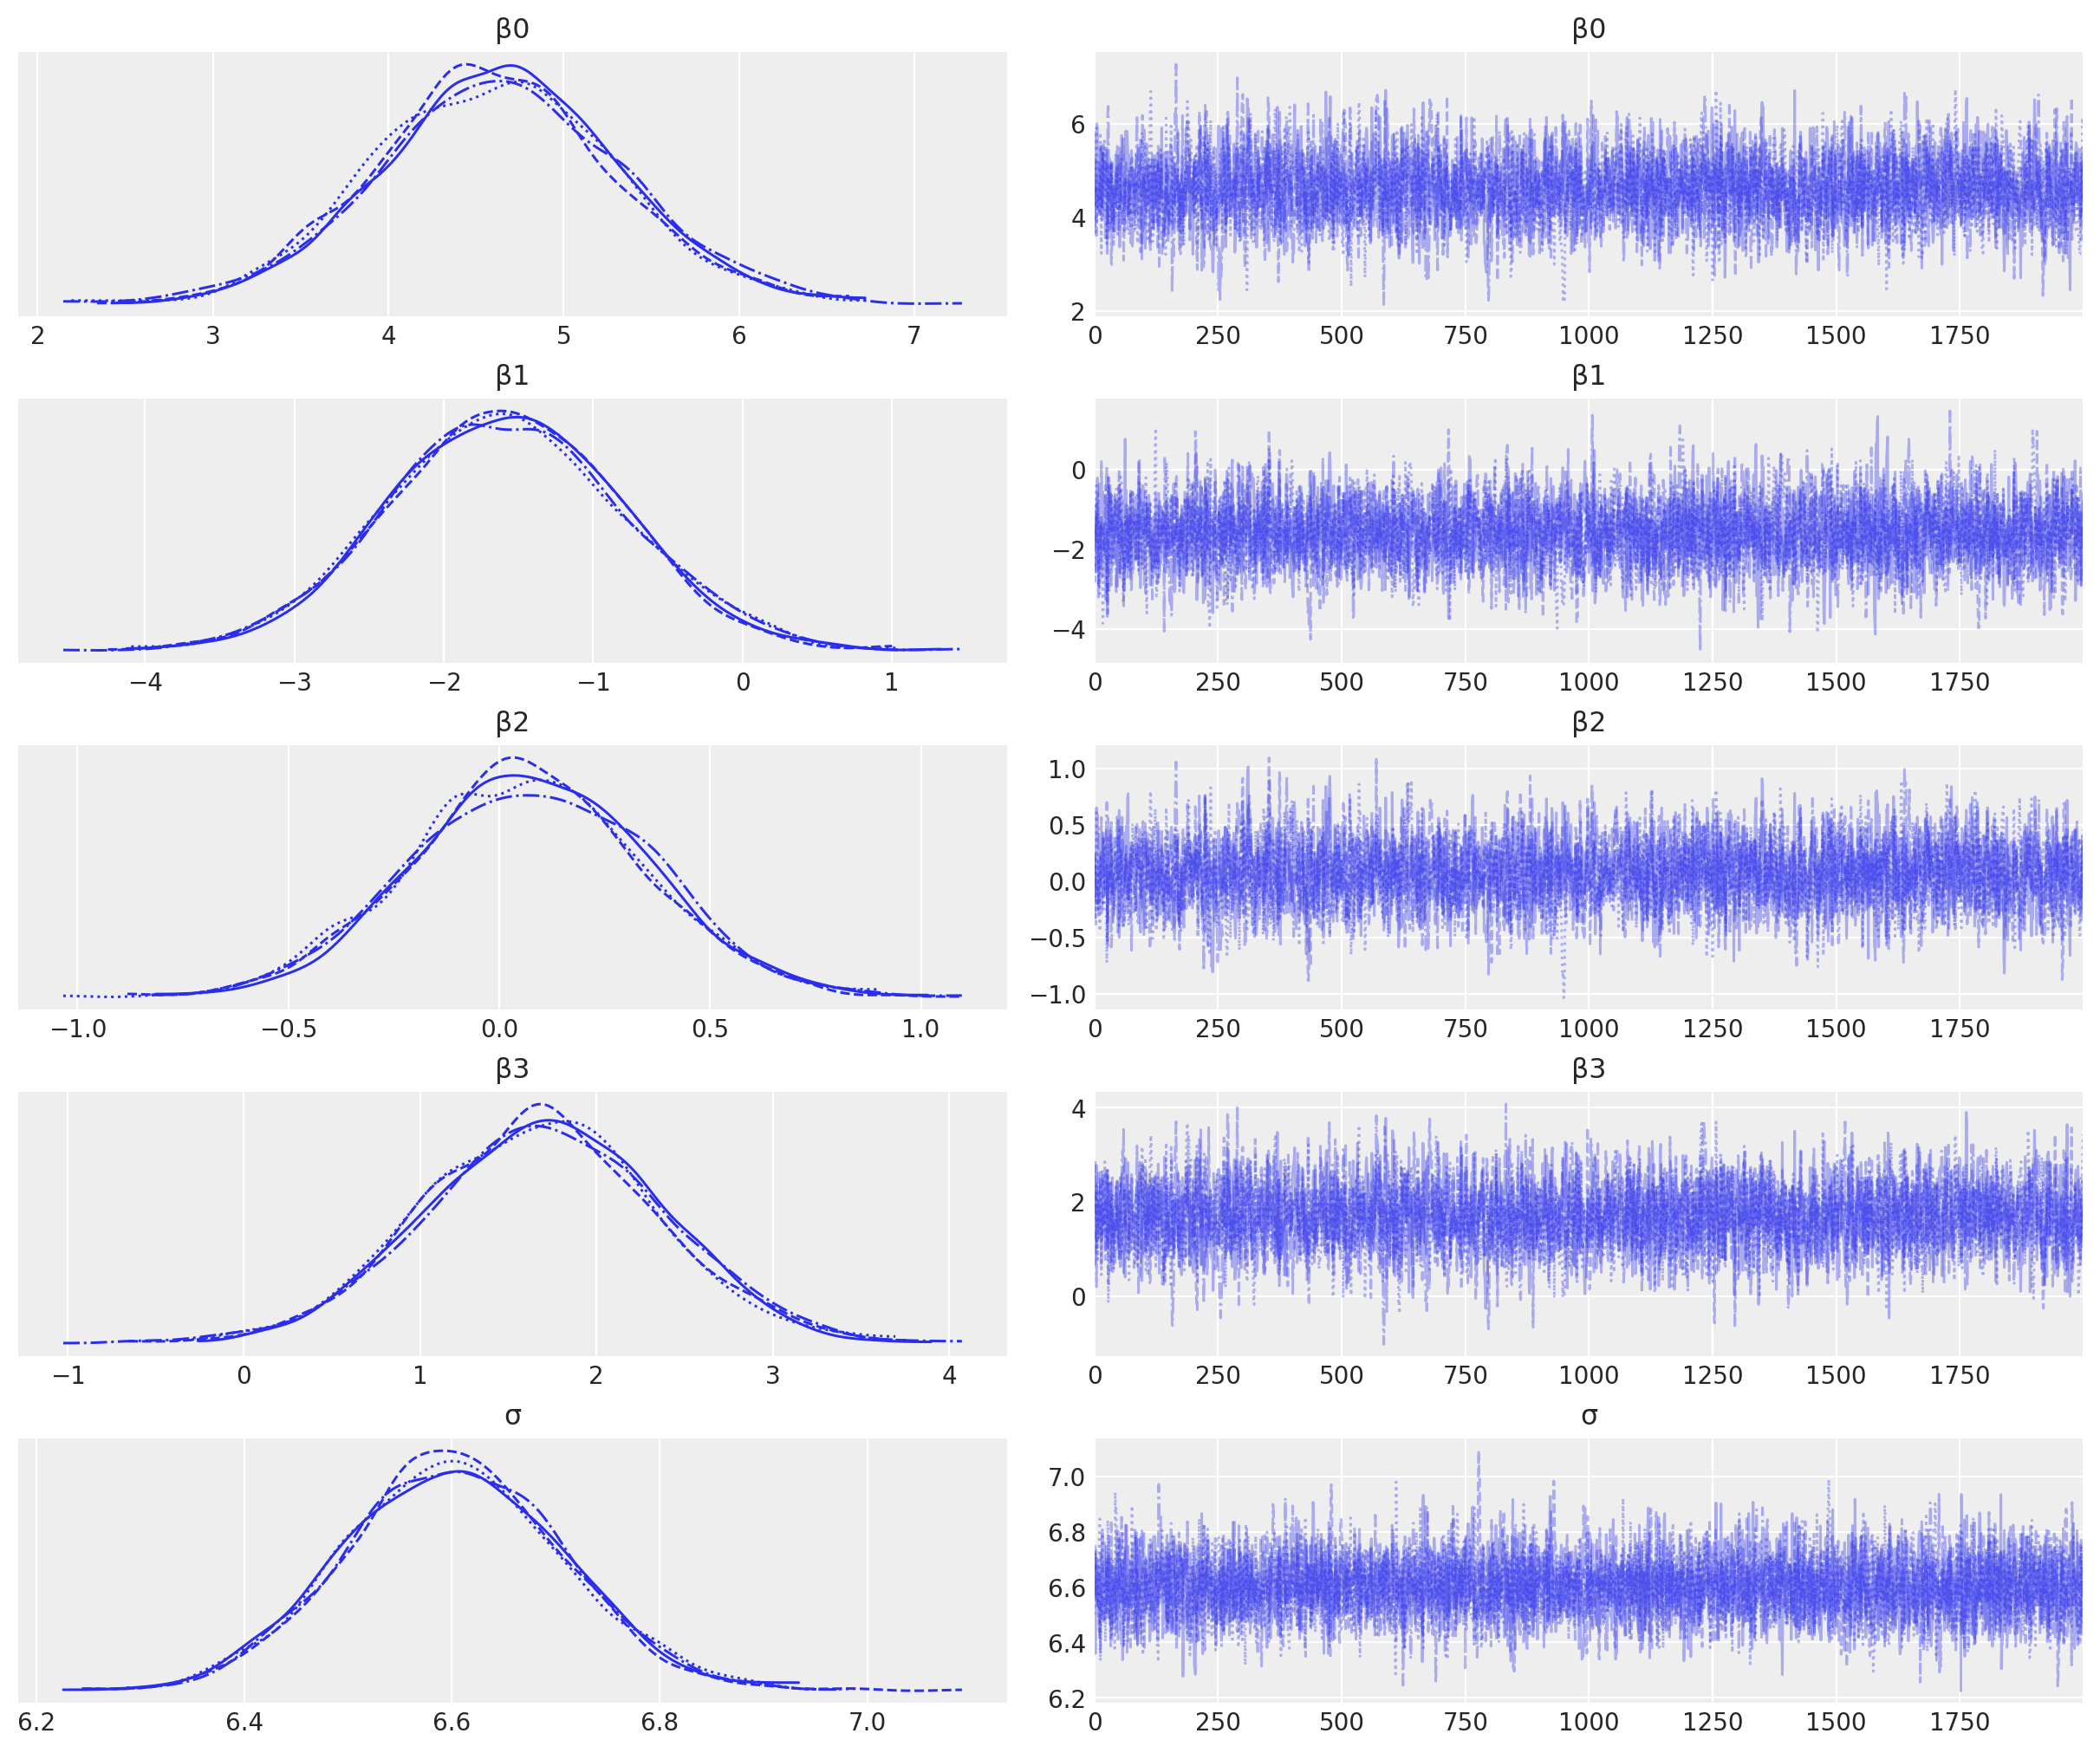

In [403]:
az.plot_trace(result);

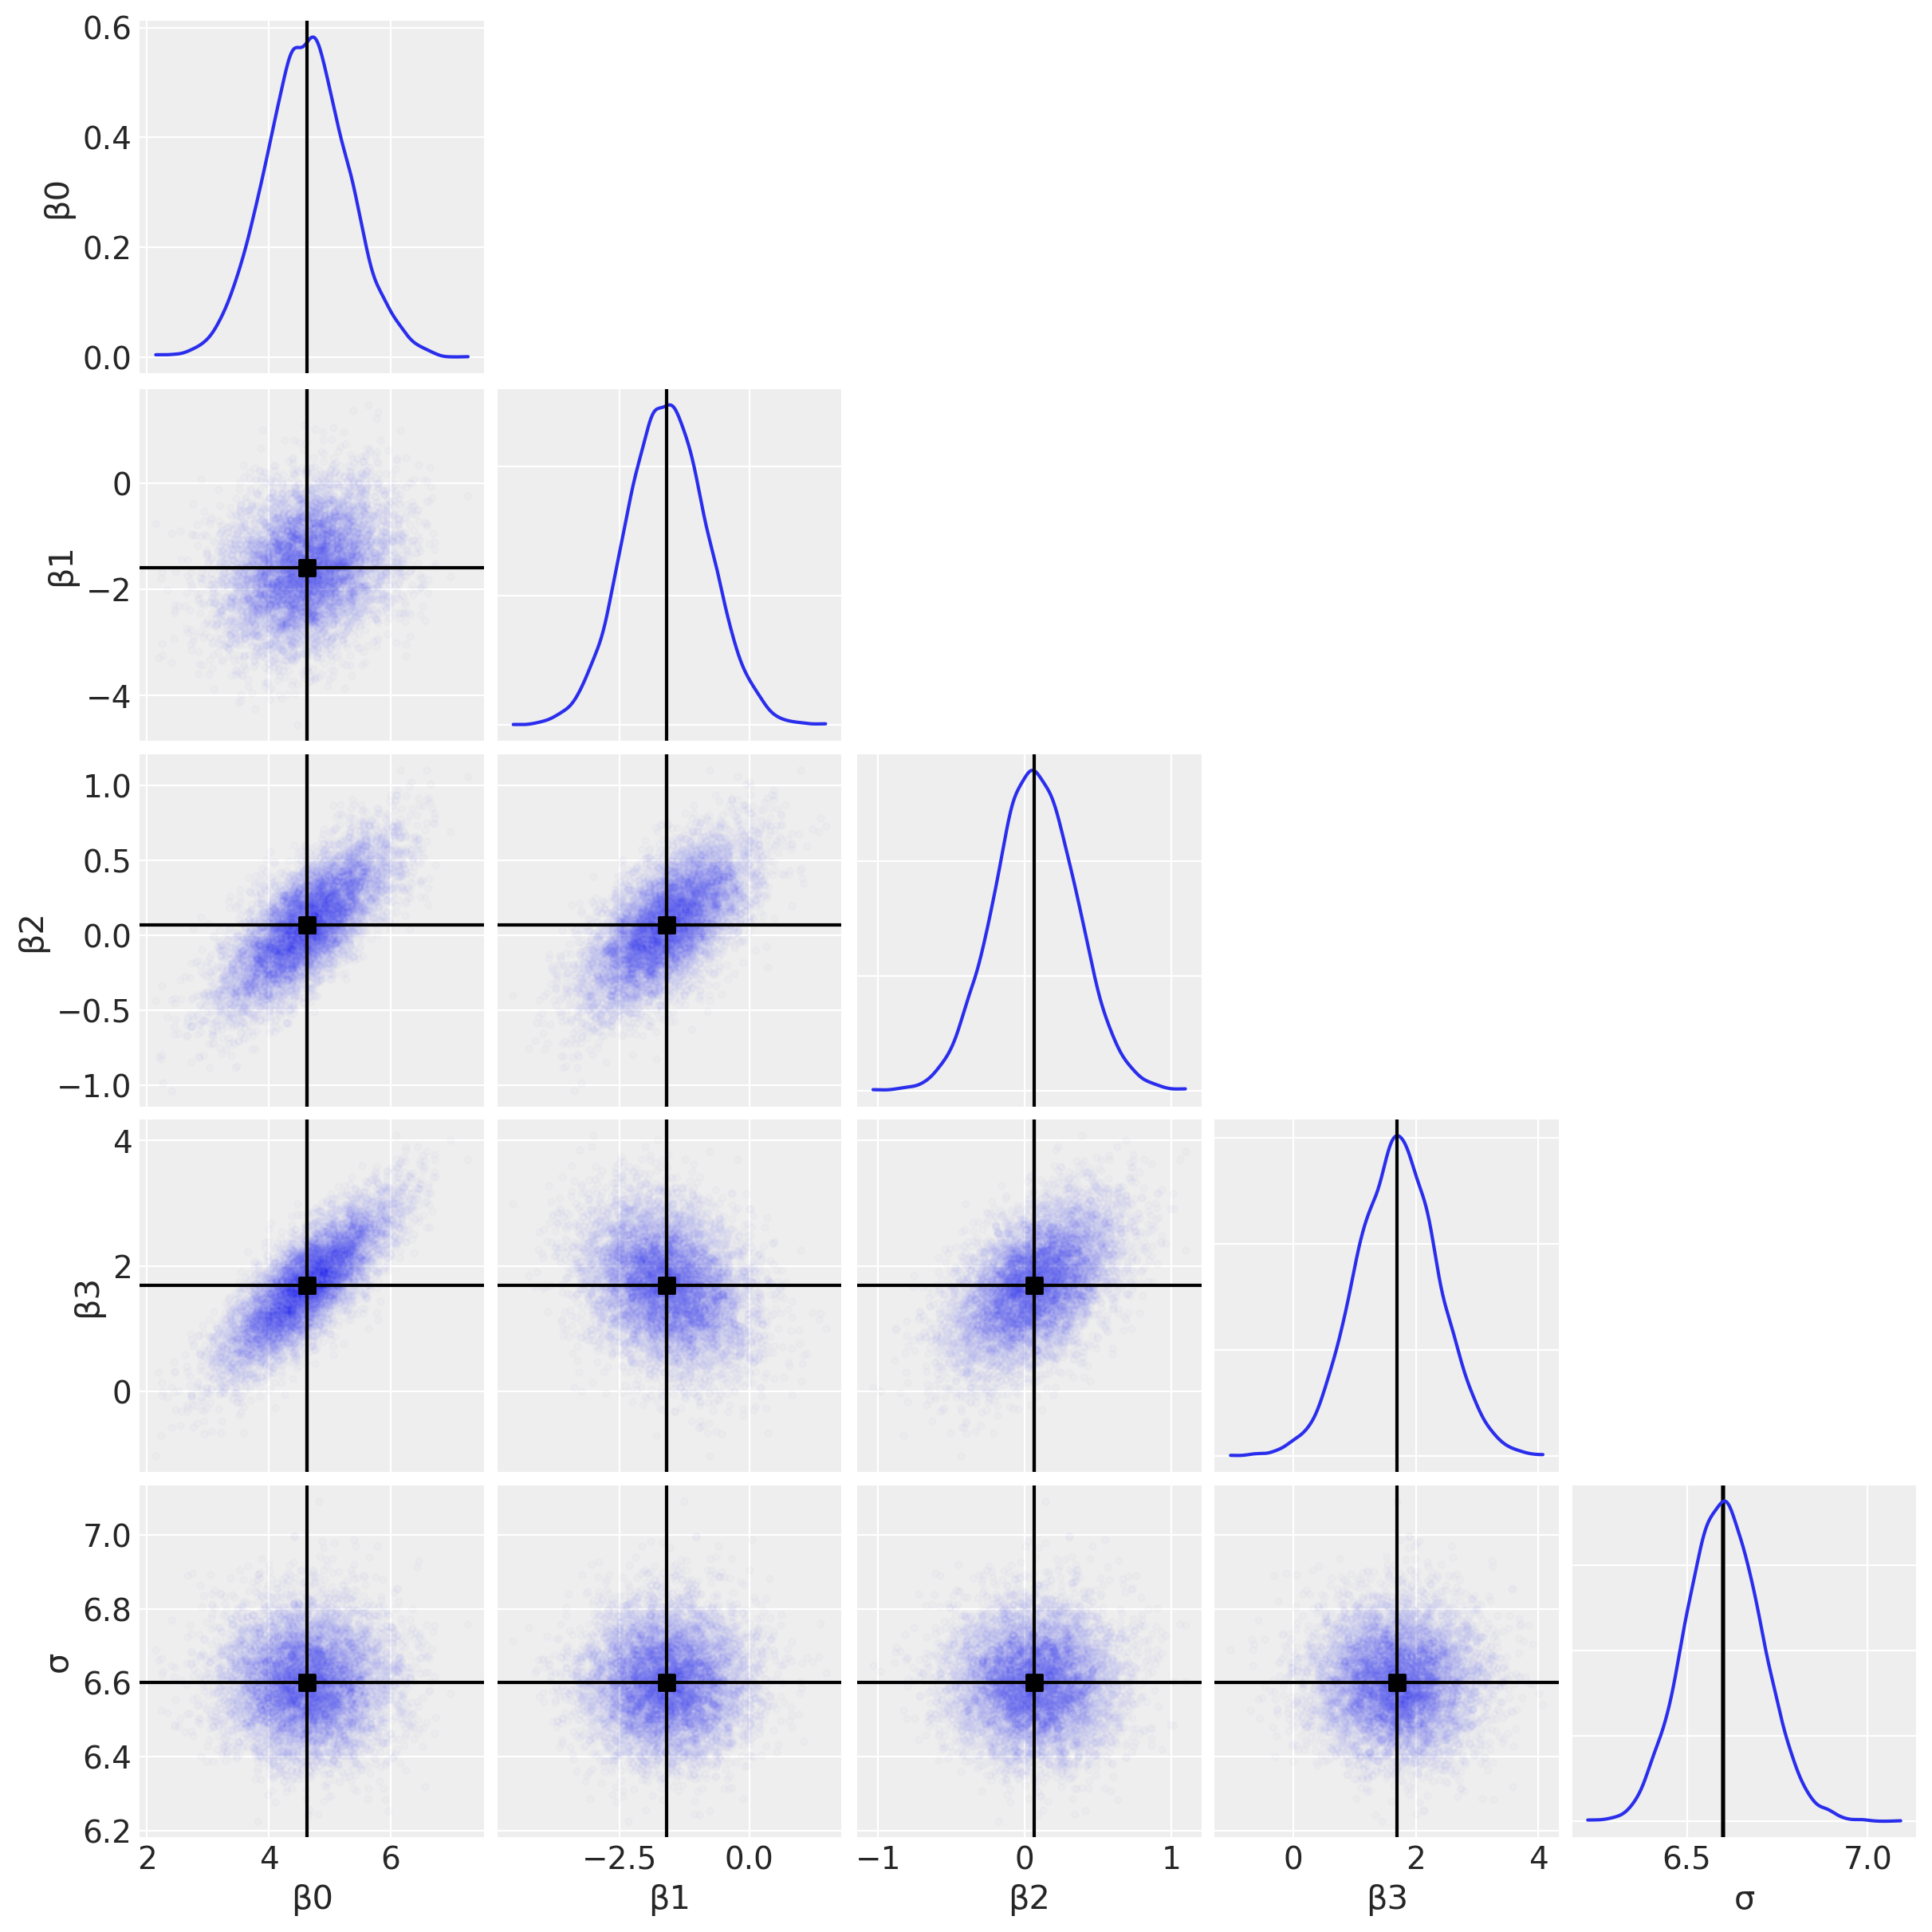

In [404]:
az.plot_pair(
    result,
    marginals=True,
    point_estimate="median",
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.01},
);

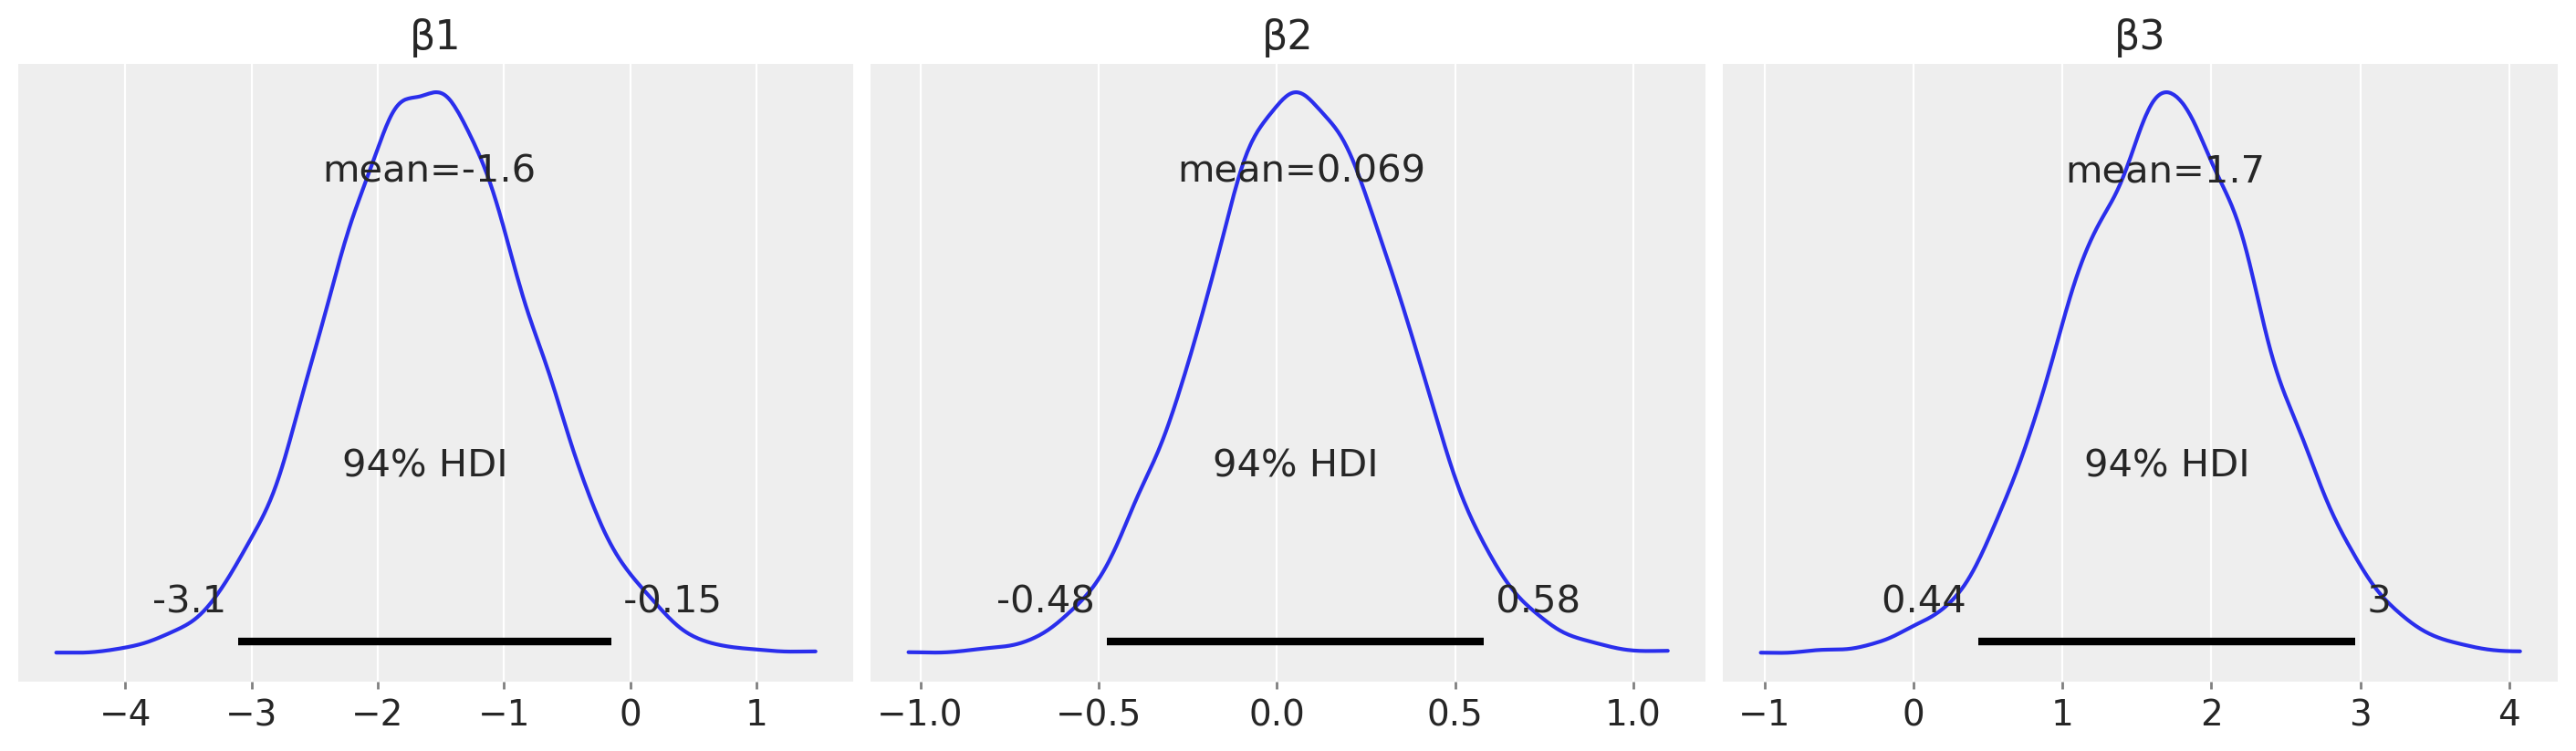

In [405]:
az.plot_posterior(result, var_names=["β1", "β2", "β3"], figsize=(14, 4));

In [406]:
m_quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

In [407]:
def plot_data(x, moderator, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    else:
        fig = plt.gcf()

    h = ax.scatter(x, y, c=moderator, cmap=scalarMap.cmap)
    ax.set(xlabel="x", ylabel="y")
    # colourbar for moderator
    cbar = fig.colorbar(h)
    cbar.ax.set_ylabel("moderator")
    return ax

In [408]:
def posterior_prediction_plot(result, x, moderator, m_quantiles, ax=None):
    """Plot posterior predicted `y`"""
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    post = result.posterior.stack(sample=("chain", "draw"))
    xi = xr.DataArray(np.linspace(np.min(x), np.max(x), 20), dims=["x_plot"])
    m_levels = result.constant_data["m"].quantile(m_quantiles).rename({"quantile": "m_level"})

    for p, m in zip(m_quantiles, m_levels):
        y = post.β0 + post.β1 * xi + post.β2 * xi * m + post.β3 * m
        region = y.quantile([0.025, 0.5, 0.975], dim="sample")
        ax.fill_between(
            xi,
            region.sel(quantile=0.025),
            region.sel(quantile=0.975),
            alpha=0.2,
            color=scalarMap.to_rgba(m),
            edgecolor="w",
        )
        ax.plot(
            xi,
            region.sel(quantile=0.5),
            color=scalarMap.to_rgba(m),
            linewidth=2,
            label=f"{p*100}th percentile of moderator",
        )

    ax.legend(fontsize=9)
    ax.set(xlabel="x", ylabel="y")
    return ax

C:\Users\Simon\AppData\Local\Temp\ipykernel_21136\9990362.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(h)


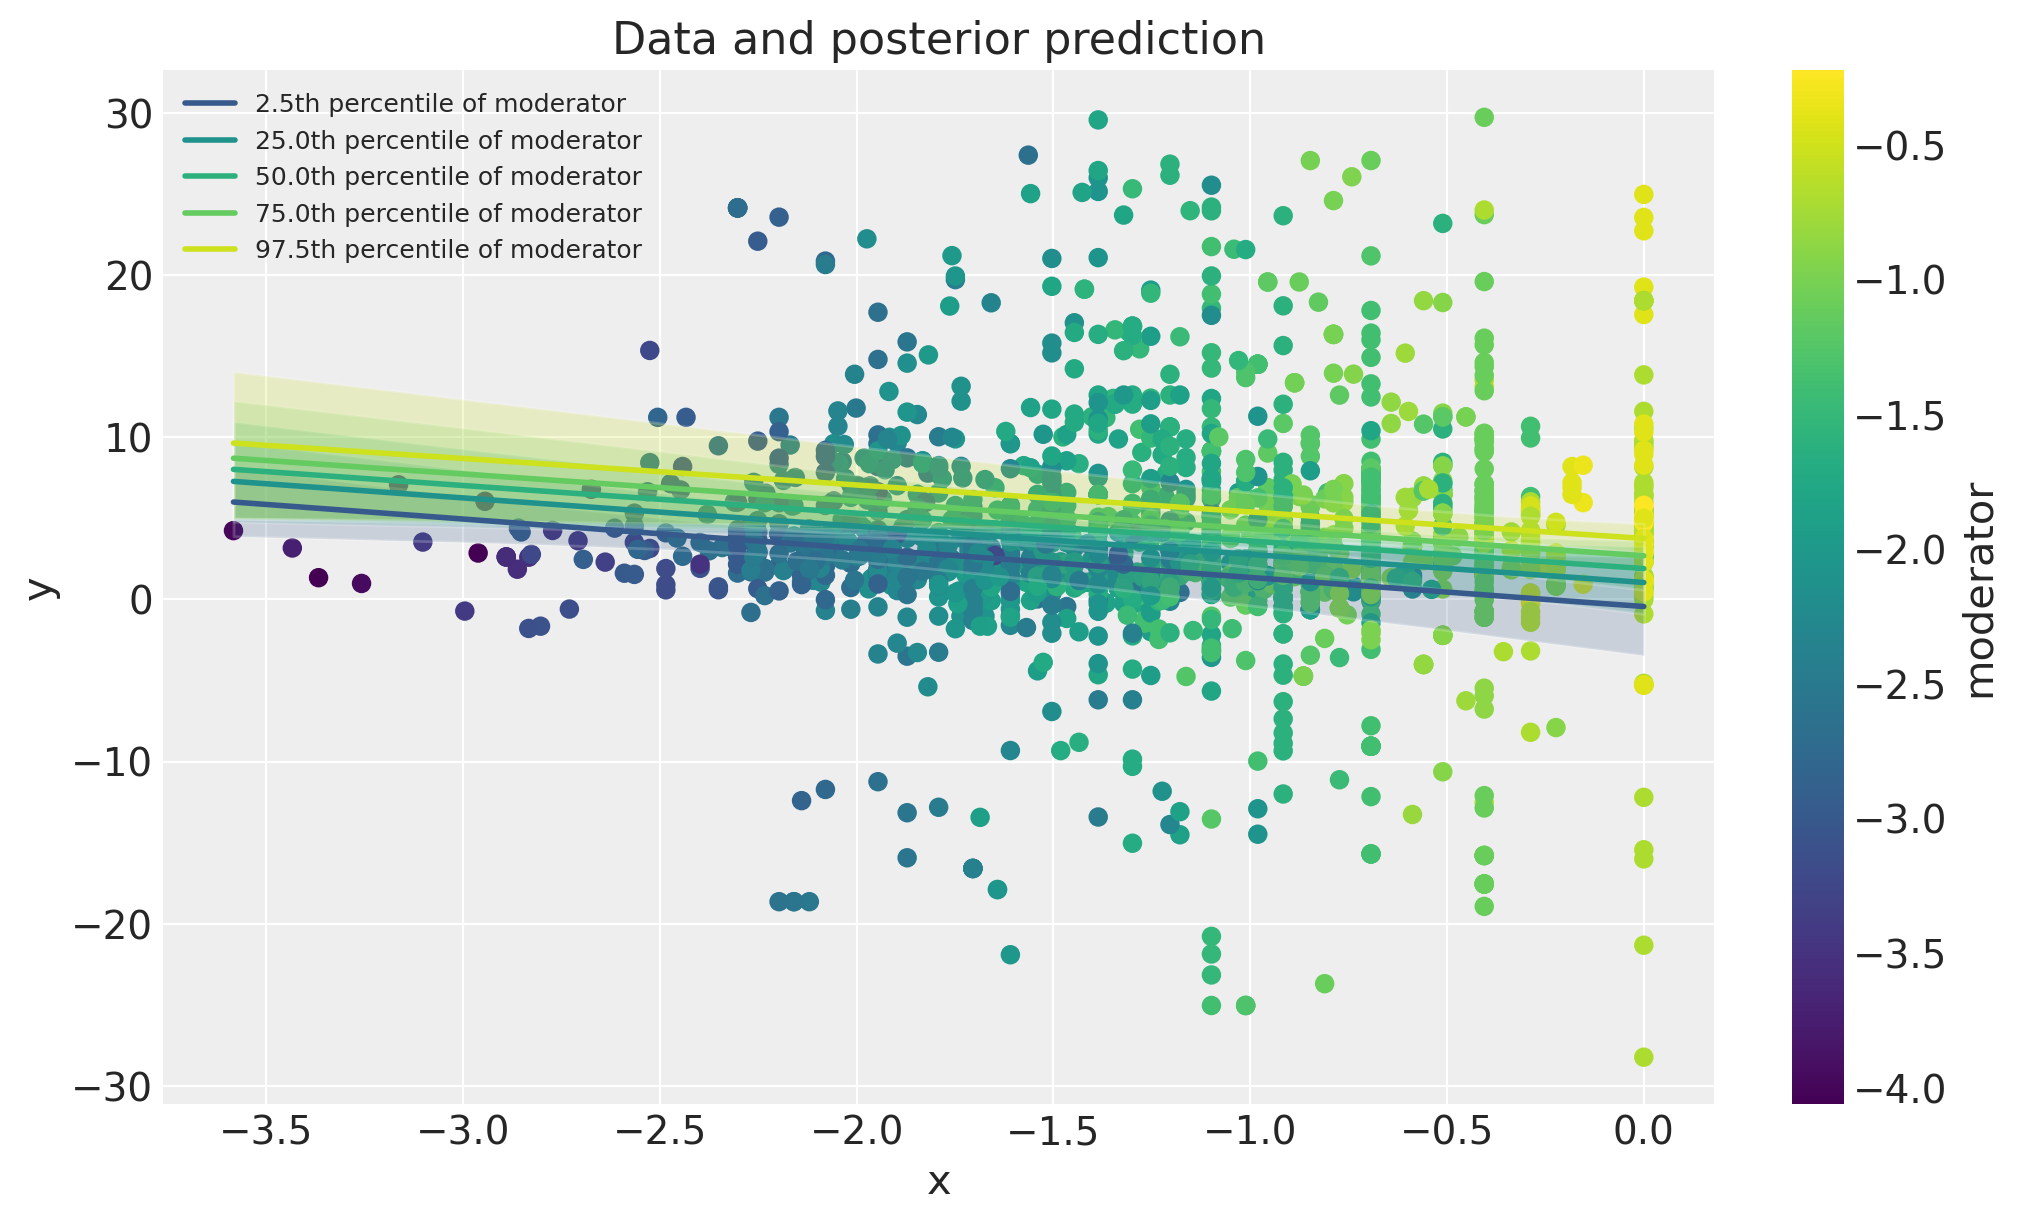

In [409]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_data(x, m, y, ax=ax)
posterior_prediction_plot(result, x, m, m_quantiles, ax=ax)
ax.set_title("Data and posterior prediction");

In [410]:
def plot_moderation_effect(m, m_quantiles, ax=None):

    if ax is None:
        fig, ax = plt.subplots(1, 1)

    post = result.posterior.stack(sample=("chain", "draw"))

    # calculate 95% CI region and median
    xi = xr.DataArray(np.linspace(np.min(m), np.max(m), 20), dims=["x_plot"])
    rate = post.β1 + post.β2 * xi
    region = rate.quantile([0.025, 0.5, 0.975], dim="sample")

    ax.fill_between(
        xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color="k",
        edgecolor="w",
    )

    ax.plot(xi, region.sel(quantile=0.5), color="k", linewidth=2)

    # plot points at each percentile of m
    percentile_list = np.array(m_quantiles) * 100
    m_levels = np.percentile(m, percentile_list)
    for p, m in zip(percentile_list, m_levels):
        ax.plot(
            m,
            np.mean(post.β1) + np.mean(post.β2) * m,
            "o",
            c=scalarMap.to_rgba(m),
            markersize=10,
            label=f"{p}th percentile of moderator",
        )

    ax.legend(fontsize=9)

    ax.set(
        title="Spotlight graph",
        xlabel="ln_%_have_undisclosed_scf",
        ylabel=r"$θ_(x→y)=\ \beta_1 + \beta_2 \cdot moderator$",
    )

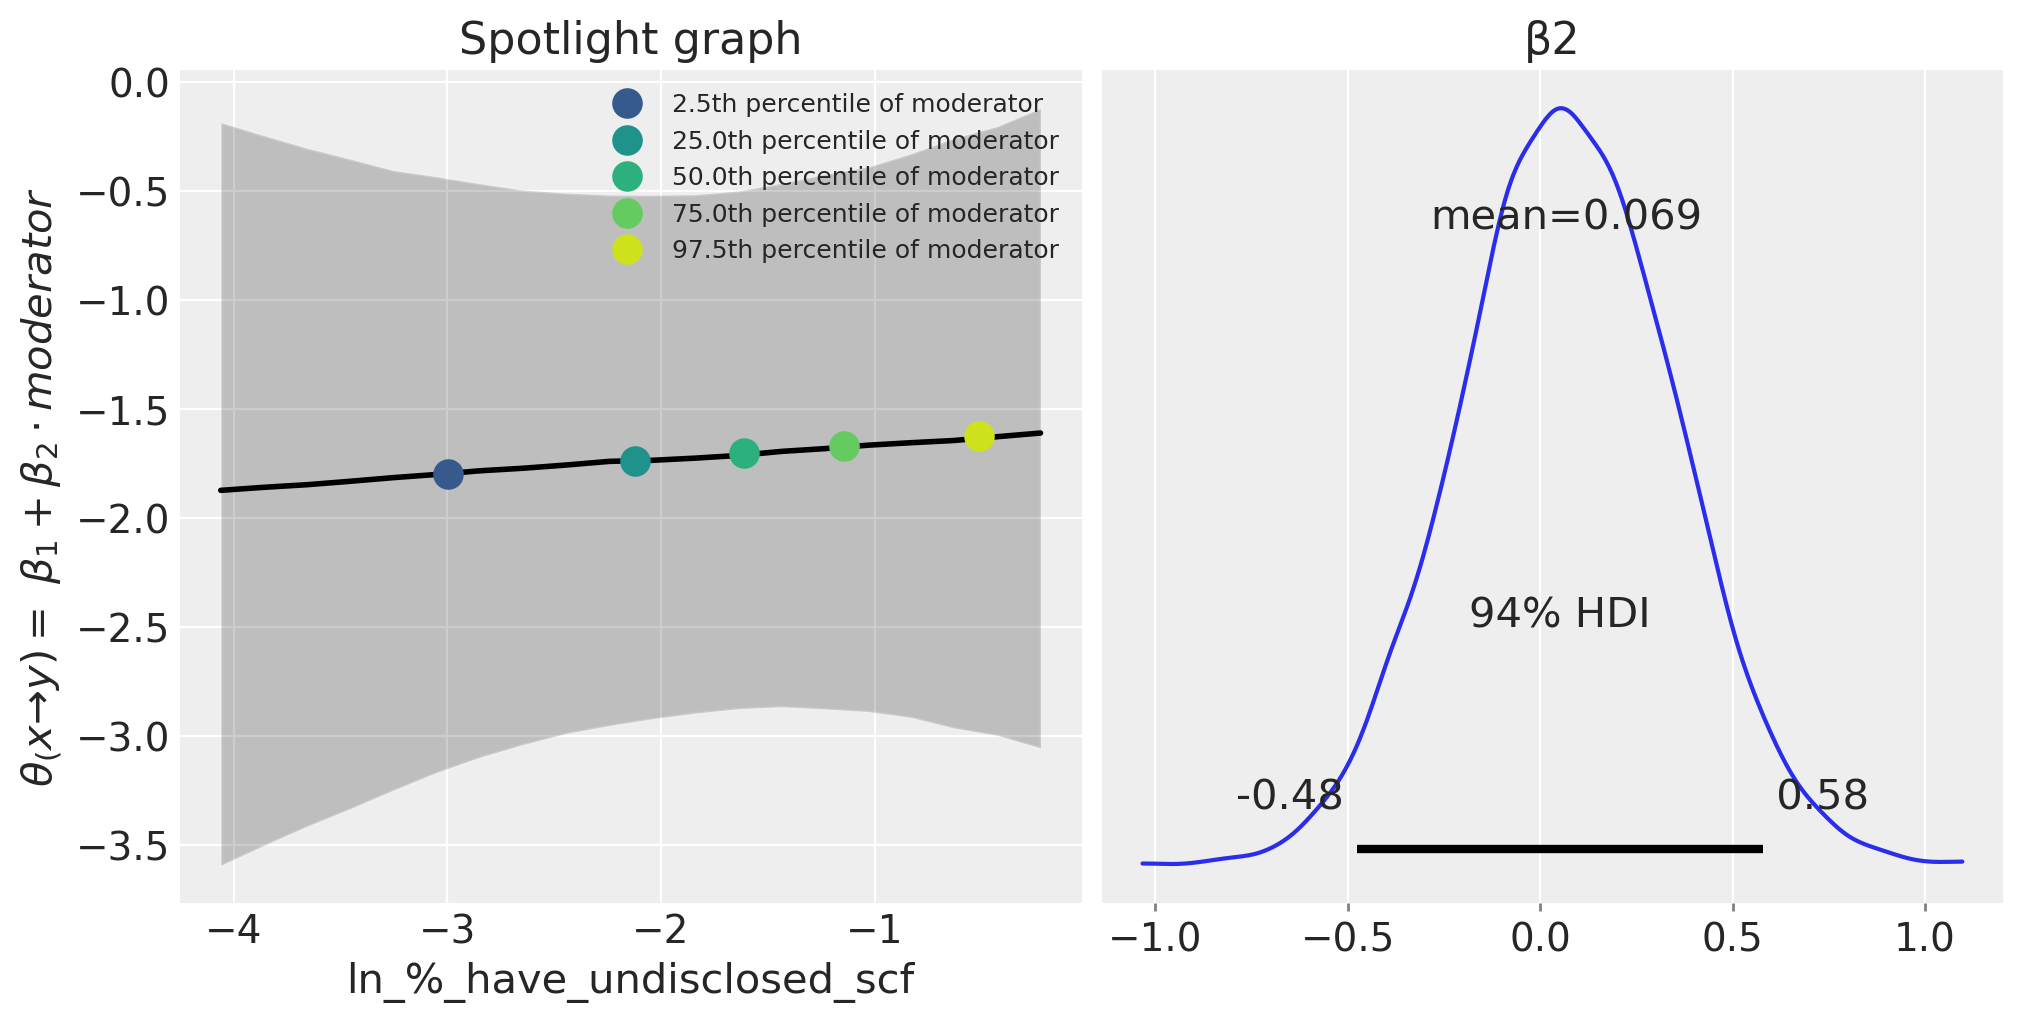

In [411]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plot_moderation_effect(m, m_quantiles, ax[0])
az.plot_posterior(result, var_names="β2", ax=ax[1]);

In [412]:
with pm.Model() as model_t:
    data = pm.Data("data", x)
    
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Deterministic('nu', pm.Exponential('nu_', 1/29) + 1)
    mu = pm.Deterministic('mu', alpha + beta * x)
    
    y_pred = pm.StudentT('y_pred', mu=mu, sd=epsilon, nu=nu, observed=y)
    
    y_mean = y.mean()
    ss_reg = pm.math.sum((mu - y_mean) ** 2)
    ss_tot = pm.math.sum((y - y_mean) ** 2)
    rss = pm.Deterministic('rss', ss_reg/ss_tot)
    


In [413]:
az.summary(result)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β0,4.620,0.687,3.354,5.945,0.012,0.008,3286.0,3510.0,1.0
β1,-1.590,0.787,-3.106,-0.148,0.013,0.009,3925.0,3827.0,1.0
β2,0.069,0.282,-0.476,0.580,0.005,0.004,3236.0,3892.0,1.0
β3,1.690,0.675,0.436,2.966,0.011,0.008,3743.0,4159.0,1.0
σ,6.602,0.106,6.397,6.791,0.002,0.001,4943.0,4757.0,1.0


In [414]:
viz = pm.model_to_graphviz(model)

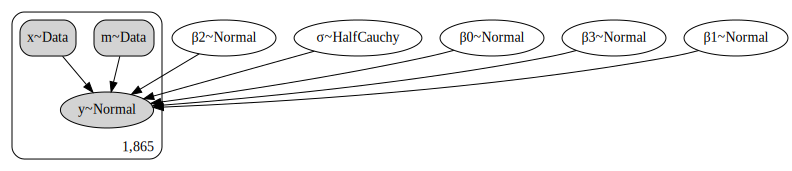

In [415]:
viz